In [1]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch

import boda
from boda.generator.parameters import BasicParameters
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

from scipy import spatial
from scipy.cluster import hierarchy

In [2]:
test_path = 'gs://syrgoth/boda_library_design_202112/pickles/sg__hepg2__hmc__track_001__round_0__20211210_221758__613002.pt'
model_paths = [
    'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
    'gs://syrgoth/aip_ui_test/model_artifacts__20211112_154705__841131.tar.gz',
    'gs://syrgoth/aip_ui_test/model_artifacts__20211113_205602__613479.tar.gz'
]

model_paths = ['gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz',
               'gs://syrgoth/aip_ui_test/model_artifacts__20211119_011437__338420.tar.gz']

In [3]:
def load_models(*model_paths):
    models = []
    if len(model_paths) > 0:
        print(f'loading {len(model_paths)} model(s)')
        for i, model_path in enumerate(model_paths):
            with tempfile.TemporaryDirectory() as tmpdirname:
                unpack_artifact(model_path, tmpdirname)
                _hold = model_fn(os.path.join(tmpdirname,'artifacts'))
                _hold.cuda()
                _hold.eval()
                models.append( _hold )
    elif len(model_paths) > 0:
        print(f'assuming pre-loaded model(s)')
        models = model_paths
        
    return models

In [4]:
model_set = load_models(*model_paths)

loading 3 model(s)


archive unpacked in /tmp/tmp0b0dyzna


Loaded model from 20211113_021200 in eval mode


archive unpacked in /tmp/tmp37wc2v3u


Loaded model from 20211110_194934 in eval mode
Loaded model from 20211119_011437 in eval mode


archive unpacked in /tmp/tmpgic62w_f


In [5]:
def list_2_tensor(seq_list):
    return torch.stack(
        [utils.dna2tensor(subsequence) for subsequence in tqdm(seq_list)]
    )

l2t = list_2_tensor

In [6]:
def load_stash(filepath):
    if 'gs://' == filepath[:5]:
        with tempfile.TemporaryDirectory() as tmpdir:
            temp_loc = os.path.join( tmpdir, os.path.basename(filepath) )
            subprocess.check_call(
                ['gsutil', 'cp', filepath, temp_loc]
            )
            stash = torch.load(temp_loc)
    else:
        stash = torch.load(filepath)
    return stash

In [7]:
left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)


def run_model(model, x):
    with torch.no_grad():
        bsz = x.shape[0]
        expander = [bsz, -1, -1]
        passthrough = BasicParameters(
            torch.randn_like(x), 
            left_flank = left_flank.expand(*expander), 
            right_flank = right_flank.expand(*expander)
        )
        passthrough.to(model.device)

        return model( passthrough(x.to(model.device)) ).cpu()

def load_stash_to_df(filepath, *model_paths, round_override=False):
    models = []
    if (len(model_paths) > 0) and isinstance(model_paths[0], str):
        models = load_models(*model_paths)
    elif len(model_paths) > 0:
        print(f'assuming pre-loaded model(s)')
        models = model_paths
    
    user, cell, gen, track_id, round_id, date_time, rand_id = os.path.basename(filepath).split('__')
    track_id = int(track_id.split('_')[1])
    date, time = [int(x) for x in date_time.split('_')]
    round_id = int(round_id.split('_')[1])
    rand_id = int(rand_id.split('.')[0])
    
    stash = load_stash(filepath)
    
    seq_list = []
    round_list = []
    
    model_results = { i: [] for i in range(len(models)) }
    
    for idx, proposal_round in enumerate(stash['proposals']):
        tensors = proposal_round['proposals']
        
        for j, model in enumerate(models):
            model_results[j].append( run_model(model, tensors) )
        
        seqs = list( utils.batch2list(tensors) )
        
        seq_list += seqs
        if round_override:
            round_list += [round_id] * len(seqs)
        else:
            round_list += [idx] * len(seqs)
        
    line_count = len(seq_list)
    
    data_dict =  {
        'sequence': seq_list,
        'penalty_round': round_list,
        'user': [ user ] * line_count,
        'generator':[ gen ] * line_count,
        'cell':[ cell ] * line_count,
        'track':[ track_id ] * line_count,
        'date':[ date ] * line_count,
        'time':[ time ] * line_count,
        'random_tag':[ rand_id ] * line_count,
    }

    relist_preds = []
    for i in range(len(models)):
        pred_set = model_results[i]
        cat_preds= torch.cat(pred_set, dim=0)
        n_preds, n_feats = cat_preds.shape
        relist_preds.append(cat_preds)
    avg_pred = torch.stack(relist_preds, dim=0).mean(0)
    for j in range(n_feats):
        data_dict[f'preds_cell_{j}'] = avg_pred[:,j].numpy()
    
    data = pd.DataFrame( data_dict )
    data['internal_index'] = np.arange(data.shape[0])
    
    return data

In [8]:
def read_fasta(file_obj):
    fasta_tags = []
    fasta_seqs = []
    
    for i, line in enumerate(file_obj.readlines()):
        if i % 2 == 0:
            fasta_tags.append(line.rstrip())
        else:
            fasta_seqs.append(line.rstrip().upper())
            
    return fasta_tags, fasta_seqs
    

def load_fasta(filepath):
    
    if 'gs://' == filepath[:5]:
        with tempfile.TemporaryDirectory() as tmpdir:
            temp_loc = os.path.join( tmpdir, os.path.basename(filepath) )
            subprocess.check_call(
                ['gsutil', 'cp', filepath, temp_loc]
            )
            with open(temp_loc, 'r') as f:
                stash = read_fasta(f)
    else:
        with open(filepath, 'w') as f:
            stash = read_fasta(f)
    return stash

def fasta_to_dataframes(filepath, *model_paths, cell_idx=0, generator='dhs'):
    models = []
    if (len(model_paths) > 0) and isinstance(model_paths[0], str):
        models = load_models(*model_paths)
    elif len(model_paths) > 0:
        print(f'assuming pre-loaded model(s)')
        models = model_paths
    
    model_results = { i: [] for i in range(len(models)) }

    fasta_tags, fasta_seqs = load_fasta(filepath)
    line_count = len(fasta_seqs)

    data_dict =  {
        'sequence': fasta_seqs,
        'penalty_round': [0] * line_count,
        'user': [ 'sr' ] * line_count,
        'generator':[ generator ] * line_count,
        'cell':[ cell_idx ] * line_count,
        'track':[ 0 ] * line_count,
        'date':[ 20211207 ] * line_count,
        'time':[ 122030 ] * line_count,
        'random_tag':[ 999999 ] * line_count,
    }
    
    onehot_sequences = torch.stack(
        [utils.dna2tensor(subsequence) for subsequence in tqdm(fasta_seqs)]
    )
    
    for j, model in enumerate(models):
        model_results[j].append( run_model(model, onehot_sequences) )
     
    relist_preds = []
    for i in range(len(models)):
        pred_set = model_results[i]
        cat_preds= torch.cat(pred_set, dim=0)
        n_preds, n_feats = cat_preds.shape
        relist_preds.append(cat_preds)
    avg_pred = torch.stack(relist_preds, dim=0).mean(0)
    for j in range(n_feats):
        data_dict[f'preds_cell_{j}'] = avg_pred[:,j].numpy()    
    
    data = pd.DataFrame( data_dict )
    data['internal_index'] = np.arange(data.shape[0])
    
    return data

In [9]:
design_df = pd.read_pickle('gs://syrgoth/boda_library_design_202112/boda_design__round_1__20211213.pkl')

In [10]:
gs_paths = !gsutil ls $'gs://syrgoth/boda_library_design_202112/extra_pickles_3'
extra_pickle_paths =[ path for path in gs_paths if ('sa_rep__' in path) ]

extra_data = pd.concat([ load_stash_to_df(path, *model_set) for path in tqdm(extra_pickle_paths) ]).reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

assuming pre-loaded model(s)


 33%|███▎      | 1/3 [00:03<00:06,  3.29s/it]

assuming pre-loaded model(s)


 67%|██████▋   | 2/3 [00:05<00:02,  2.76s/it]

assuming pre-loaded model(s)


100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


In [11]:
extra_data['selected'] = False

new_data = pd.concat([design_df, extra_data]).reset_index(drop=True)

In [12]:
def tidy_activities(data,x_tag):
    y_tags = ['preds_cell_0','preds_cell_1','preds_cell_2']
    new_df = pd.DataFrame(
        np.concatenate( [ data.loc[:,[x_tag, tag]].values for tag in y_tags ], axis=0 ), 
        columns=[x_tag, 'pred_value']
    )
    new_df['pred_id'] = np.arange(len(y_tags)).repeat(data.shape[0])
    return new_df.astype({x_tag:str,'pred_value':float,'pred_id': int})

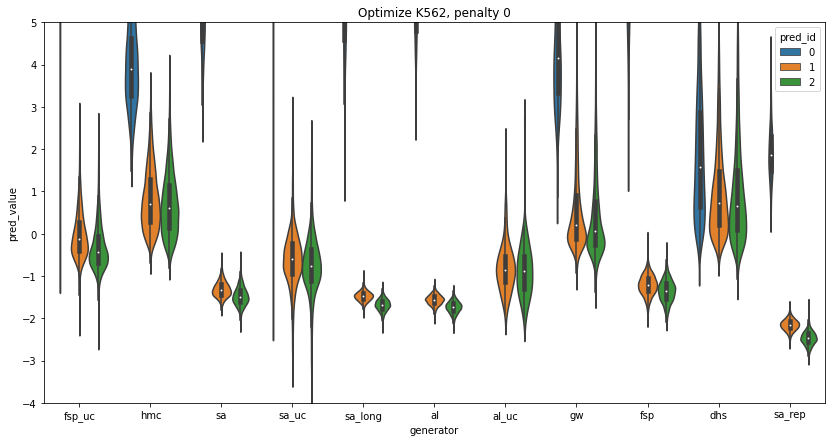

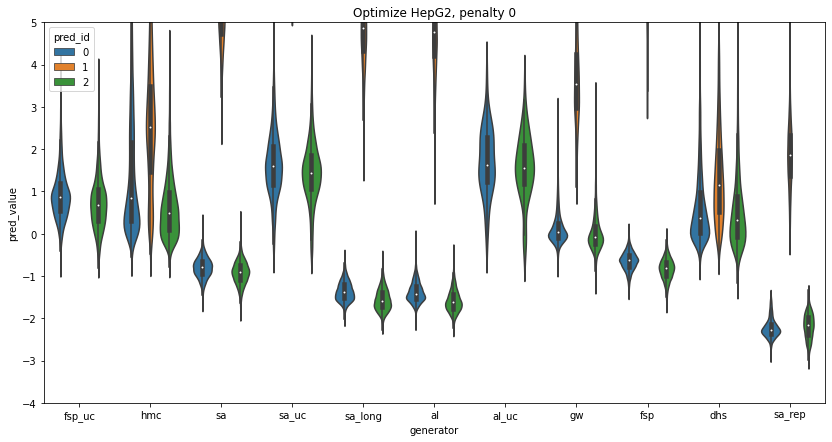

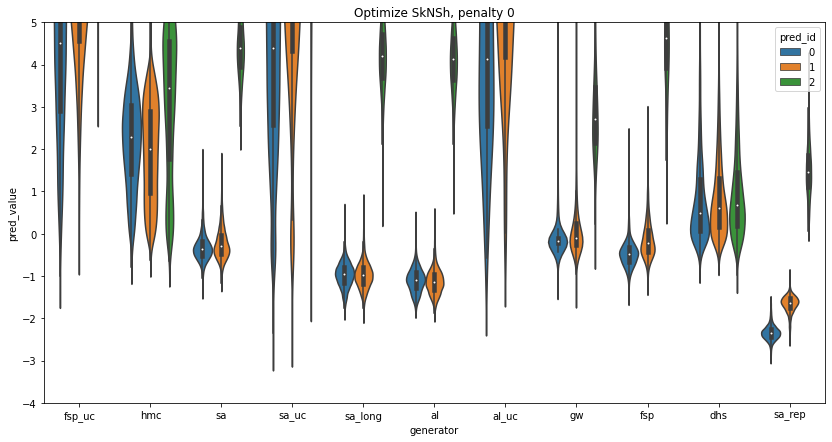

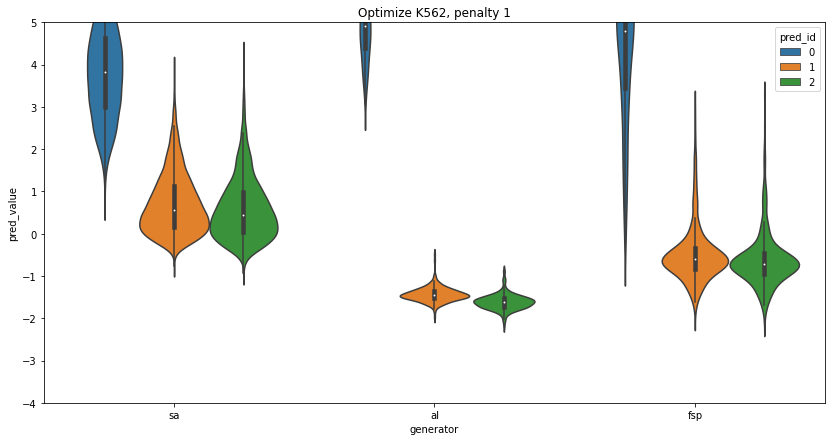

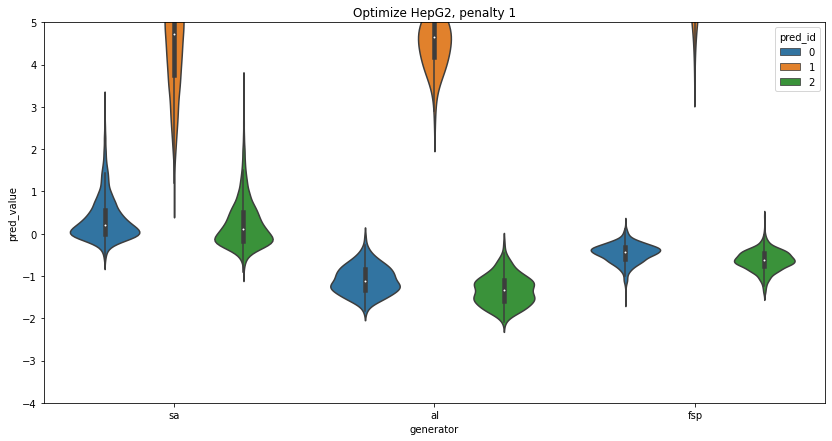

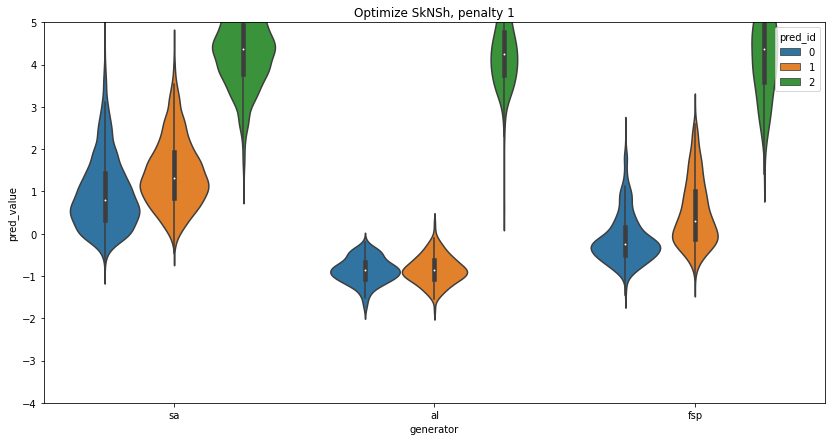

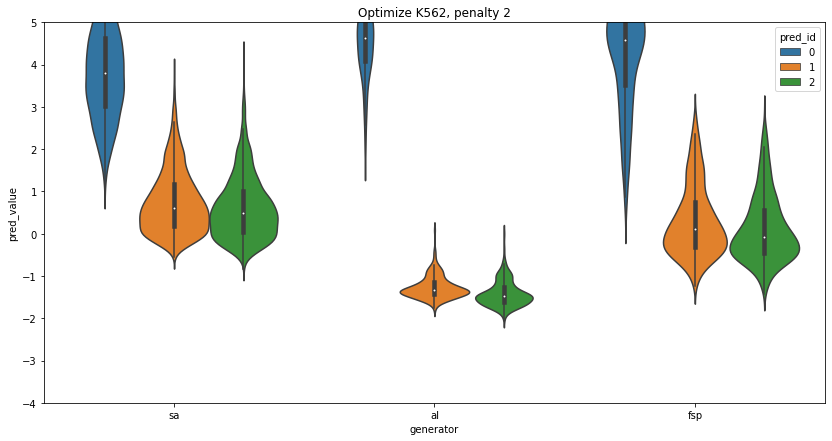

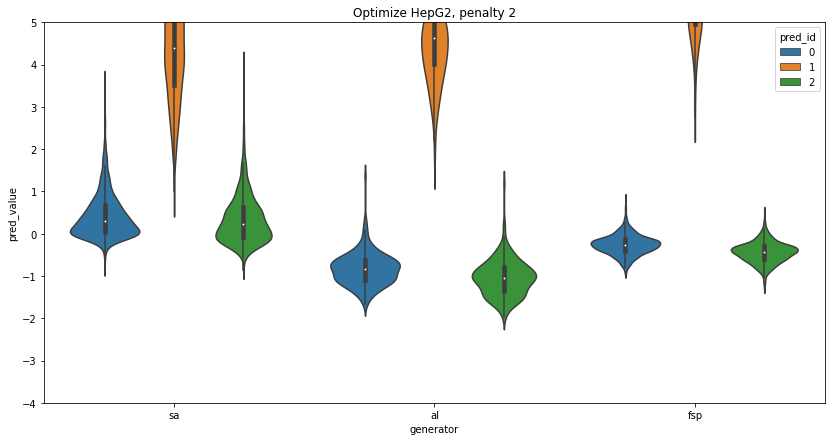

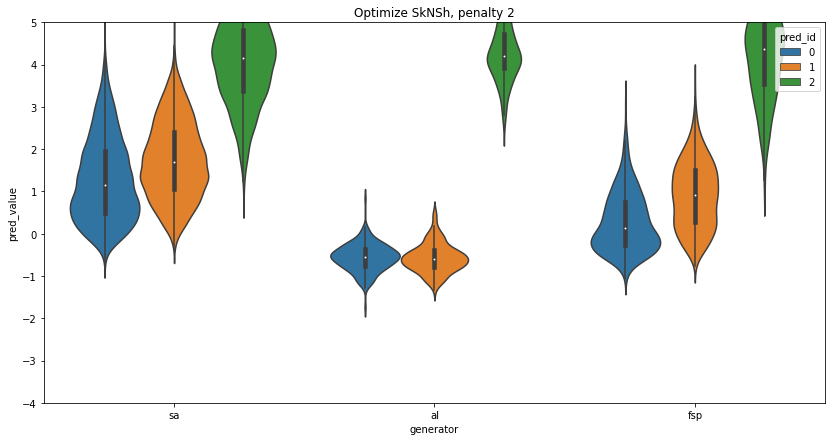

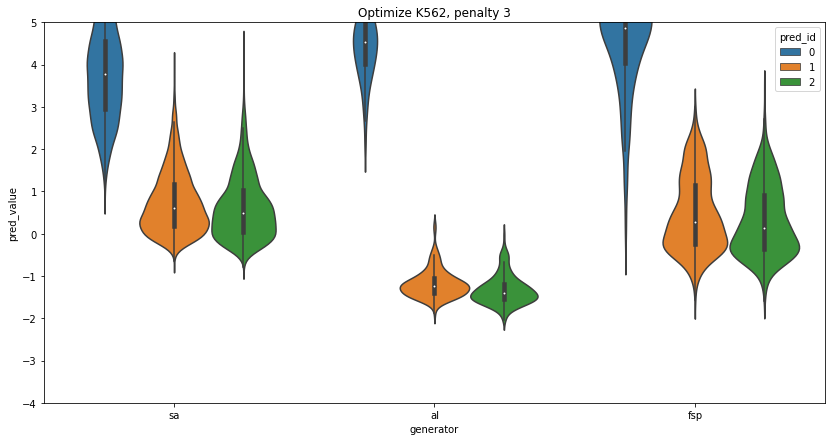

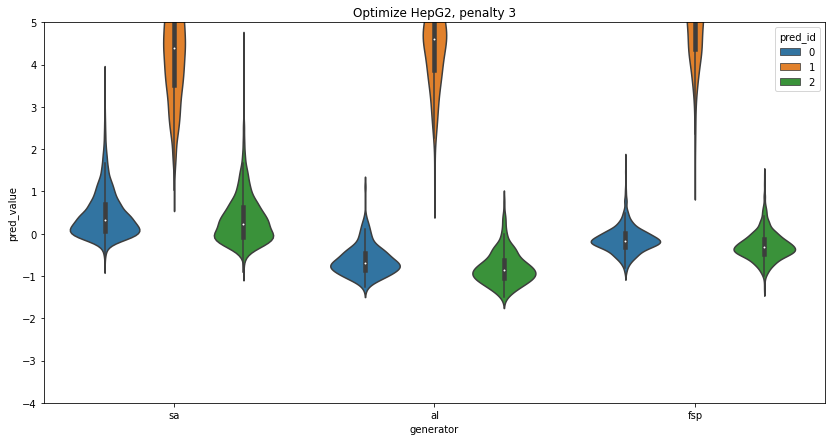

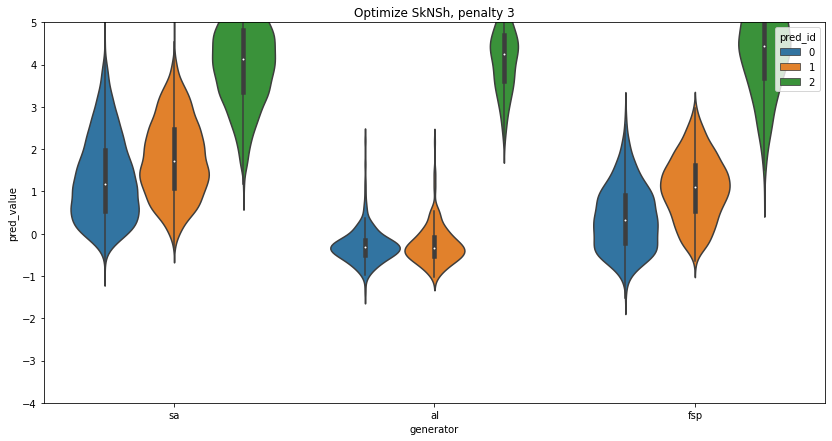

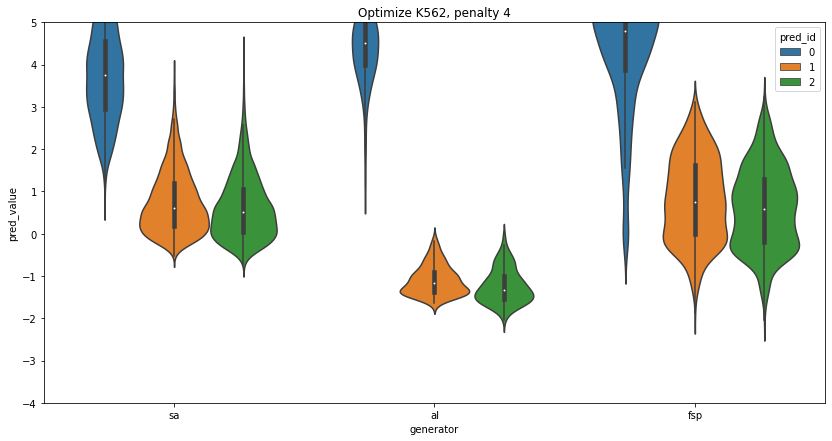

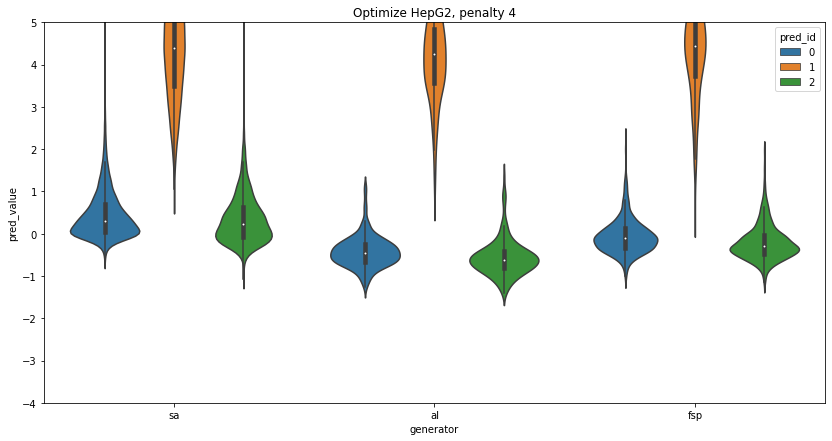

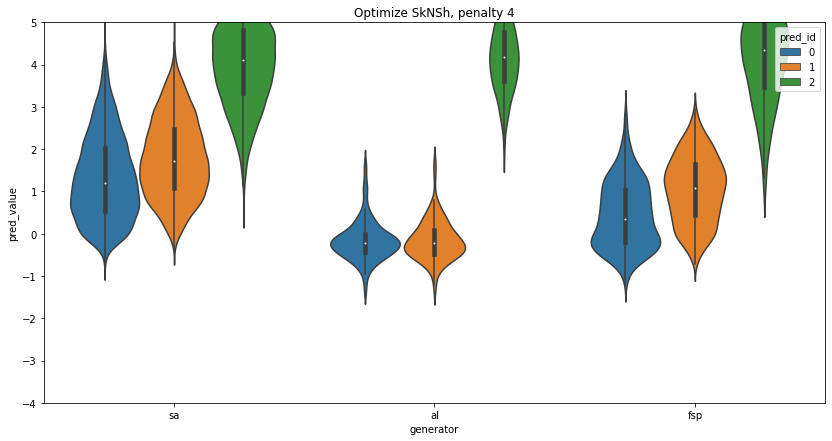

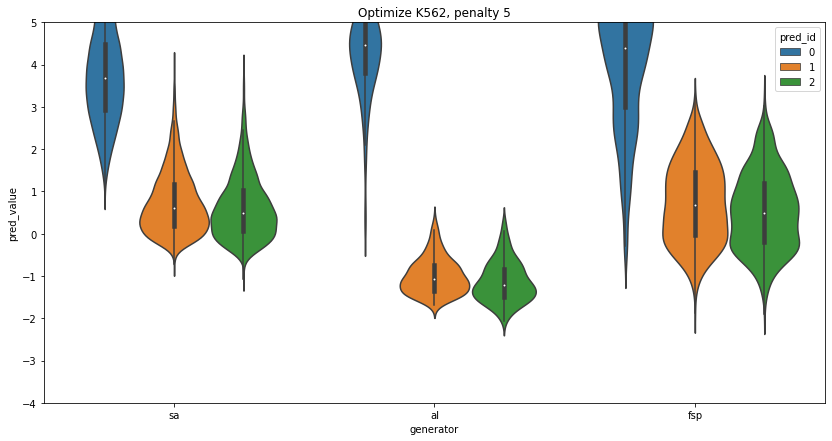

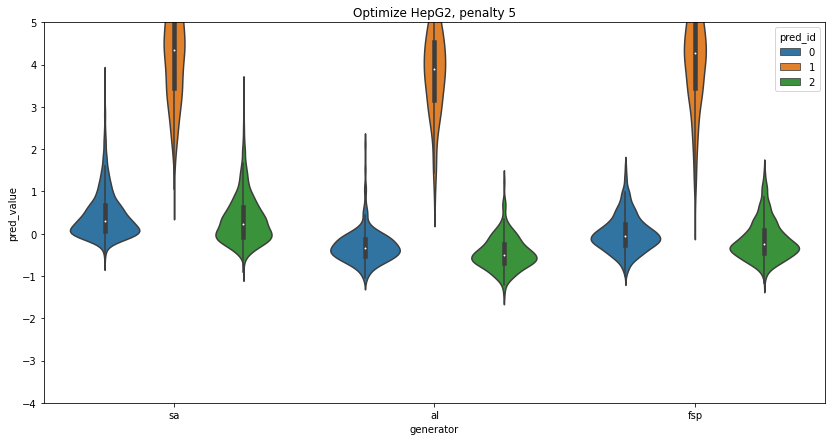

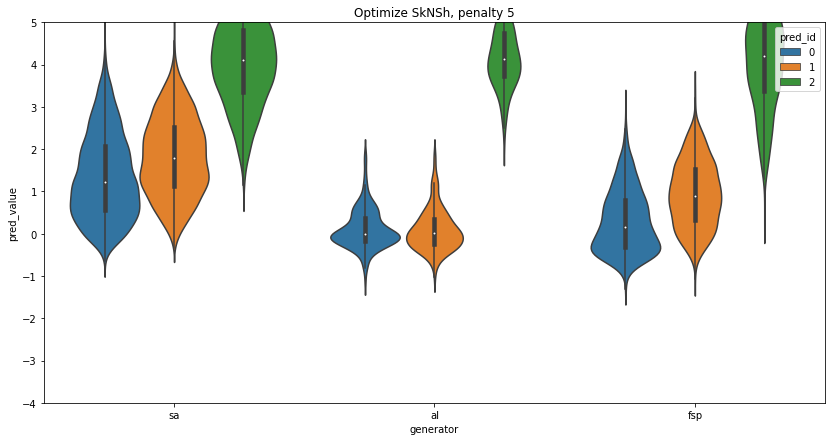

In [13]:
for pi in range(6):

    pick_cell = 'k562'

    plt.figure(figsize=(14,7))
    plt.title(f"Optimize K562, penalty {pi}")
    sns.violinplot( 
        data=tidy_activities(
            new_data[ (new_data['penalty_round'] == pi) & (new_data['cell'] == pick_cell) ], 
            'generator'
        ),
        x='generator',
        y='pred_value',
        hue='pred_id'
    )
    plt.ylim(-4,5)
    plt.show()

    pick_cell = 'hepg2'

    plt.figure(figsize=(14,7))
    plt.title(f"Optimize HepG2, penalty {pi}")
    sns.violinplot( 
        data=tidy_activities(
            new_data[ (new_data['penalty_round'] == pi) & (new_data['cell'] == pick_cell) ], 
            'generator'
        ),
        x='generator',
        y='pred_value',
        hue='pred_id'
    )
    plt.ylim(-4,5)
    plt.show()

    pick_cell = 'sknsh'

    plt.figure(figsize=(14,7))
    plt.title(f"Optimize SkNSh, penalty {pi}")
    sns.violinplot( 
        data=tidy_activities(
            new_data[ (new_data['penalty_round'] == pi) & (new_data['cell'] == pick_cell) ], 
            'generator'
        ),
        x='generator',
        y='pred_value',
        hue='pred_id'
    )
    plt.ylim(-4,5)
    plt.show()



In [14]:
def selection_assignment(data, slicer, n_selected):
    slicer_copy = copy.deepcopy(slicer)
    
    slicer_as_indices = slicer.values.nonzero()[0]
    n_sliced = slicer_as_indices.shape[0]
    passed_idx = np.random.choice( slicer_as_indices, size=min(n_sliced,n_selected), replace=False )
    
    slicer_copy[:] = False
    slicer_copy[passed_idx] = True
    
    print(f'subsetting {slicer.sum()} items', file=sys.stderr)
    data.loc[slicer, 'selected'] = False
    
    print(f'down to {slicer_copy.sum()} items', file=sys.stderr)
    data.loc[slicer_copy, 'selected'] = True
    
    return data.loc[slicer_copy]

def make_selections(data, gen_list, cell_list, pen_list, n_items):
    for gen in gen_list:
        for cell in cell_list:
            for pen in pen_list:
                print(f'collecting {cell} specific sequences made with {gen}, and {pen} penalties', file=sys.stderr)
                slicer = (data['penalty_round'] == pen) & \
                         (data['cell'] == cell) & \
                         (data['generator']==gen)
                
                selection_assignment(data, slicer, n_items)
                
    print(f'\ttagged {data["selected"].sum()} sequences for synthesis so far', file=sys.stderr)
    
def dump_pandas_to_fasta(data, fasta_path):

    hold_path = fasta_path.split('.')
    hold_path[-1] = 'pkl'
    hold_path = '.'.join(hold_path)
    
    data.to_pickle(hold_path)
    
    with tempfile.TemporaryDirectory() as tempdir:
        temp_loc = os.path.join(tempdir, 'dump.txt')
        with open(temp_loc, 'w') as f:
        
            for idx, row in tqdm( data[ data['selected'] == True ].iterrows() ):

                date = row['date']
                time = row['time']
                random_tag = row['random_tag']
                internal_index = row['internal_index']

                gen = row['generator']
                cell= row['cell']
                pen = row['penalty_round']

                carrot_line = f'>{date}_{time}__{random_tag}__{internal_index}::{gen}__{cell}__{pen}'
                seq_line    = row['sequence']

                print(carrot_line, file=f)
                print(seq_line, file=f)
                
        if 'gs://' == fasta_path[:5]:
            subprocess.check_call(
                ['gsutil', 'cp', temp_loc, fasta_path]
            )
        else:
            shutil.copyfile(temp_loc, fasta_path)

In [15]:
new_data.loc[ new_data['generator'] == 'sa_long', 'selected' ] = False

make_selections(
    data=new_data, 
    gen_list=['sa_rep'], 
    cell_list=['k562','hepg2','sknsh'],
    pen_list=[0],
    n_items=4000
)

collecting k562 specific sequences made with sa_rep, and 0 penalties
subsetting 4000 items
down to 4000 items
collecting hepg2 specific sequences made with sa_rep, and 0 penalties
subsetting 4000 items
down to 4000 items
collecting sknsh specific sequences made with sa_rep, and 0 penalties
subsetting 4000 items
down to 4000 items
	tagged 117900 sequences for synthesis so far


In [16]:
dump_pandas_to_fasta(
    data=new_data, 
    fasta_path=f'gs://syrgoth/boda_library_design_202112/boda_design__round_1__{time.strftime("%Y%m%d")}.fa'
)

117900it [00:13, 8659.54it/s]
